In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# import the PyCBC package
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

import pycbc
from pycbc.waveform.waveform import get_fd_waveform

# set font size of labels
plt.rcParams.update({'font.size': 15})

In [2]:
# define constants
f_lower = 10
f_upper = 1000

# frequency spacing
delta_f = 1.0 / 16

In [3]:
# define the inner product
def inner_product(h1, h2, Sn, df):
    """Calculate the inner product of two waveforms h1 and h2."""
    return np.abs(np.sum(np.conj(h1) * h2 / Sn)) * df

# define a function that calculates the SNR:
def SNR(a, b, Sn, frequency_spacing):
    """
    Calculate the SNR of a signal a in the presence of noise b.
    """
    # 
    inner = inner_product(a, b, Sn, frequency_spacing)
    return np.sqrt(inner * 4)

## Qn1. Download and plot the time series data


In [4]:
# read data from file
data = np.loadtxt('data/data.txt')
data.shape

(1048576, 2)

In [5]:
sample_times = data[:, 0]
measured_strain = data[:, 1]

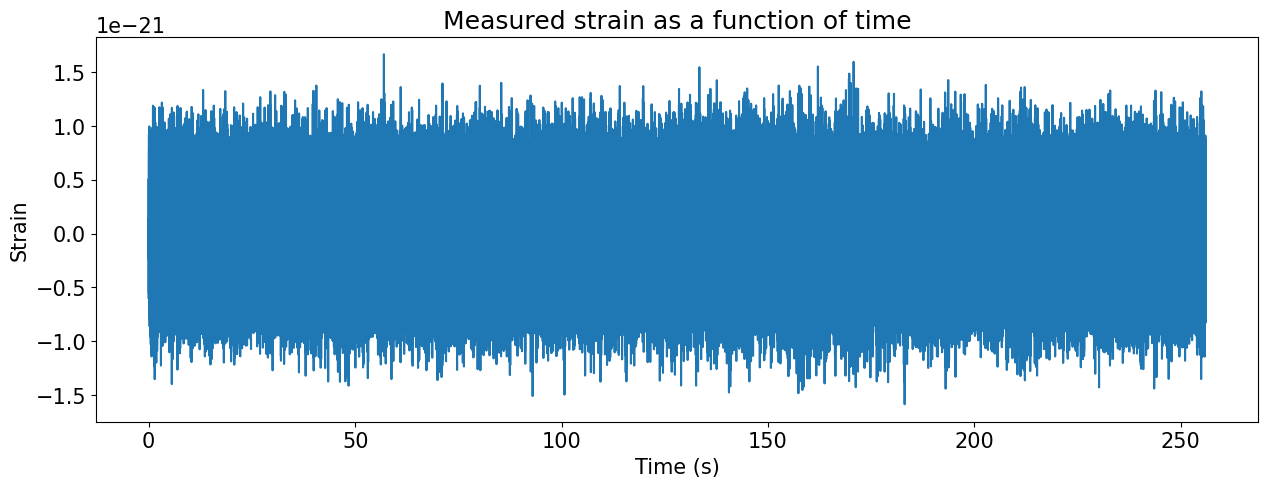

In [6]:
# plot the measured strain as a function of time
plt.figure(figsize=(15, 5))
plt.plot(sample_times, measured_strain)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Measured strain as a function of time')
plt.savefig('figures/simulated_data_time_series.png')
plt.show()


## Qn2 Use a Welch Periodogram to estimate the power spectral density of the time series data.

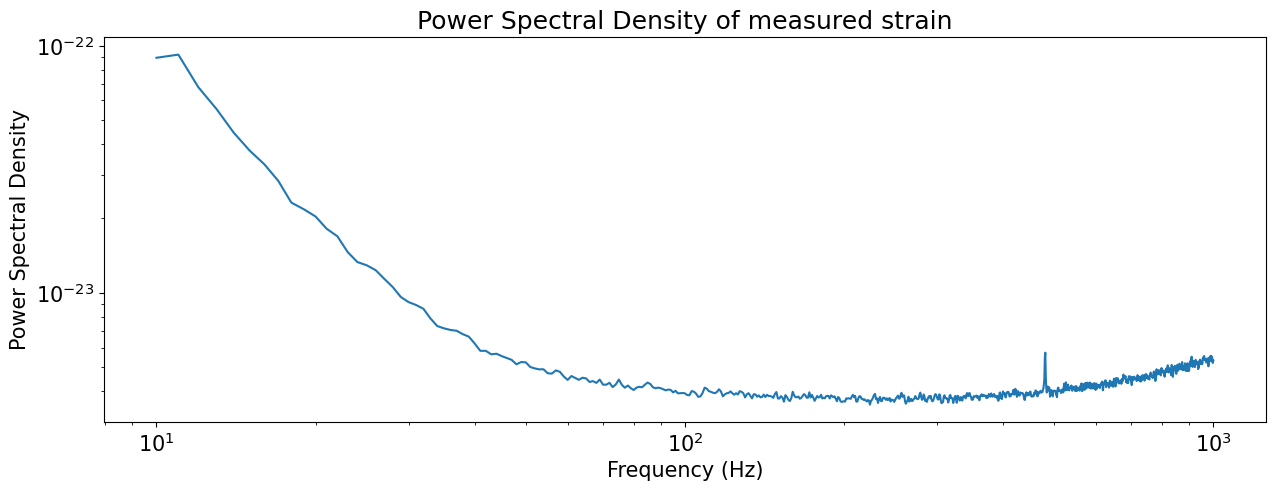

In [7]:
# use the Welch method to estimate the power spectral density of the measured strain
from scipy.signal import welch

freq_psd, observed_psd = welch(measured_strain, fs=1/(sample_times[1] - sample_times[0]), nperseg=4096)

# filter the data with in the frequency range
observed_psd = observed_psd[(freq_psd >= f_lower) & (freq_psd <= f_upper)]
freq_psd = freq_psd[(freq_psd >= f_lower) & (freq_psd <= f_upper)]




plt.figure(figsize=(15, 5))



plt.plot(freq_psd, np.sqrt(observed_psd))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density of measured strain')
plt.xscale('log')
plt.yscale('log')
plt.savefig('figures/observed_psd.png')
plt.show()

In [8]:
# compare with expected ASD
expected_asd = np.loadtxt('data/ASD.txt')
expected_asd_frequencies = expected_asd[:, 0]
expected_asd_values = expected_asd[:, 1]


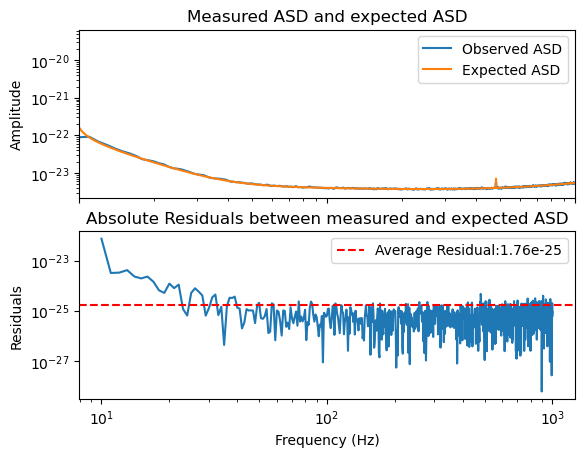

In [9]:
# create two subplots
# set font size 
plt.rcParams.update({'font.size': 10})

# 1. plot the expected ASD and the filtered Fourier transform
plt.subplot(2, 1, 1)
plt.plot(freq_psd, np.sqrt(observed_psd), label='Observed ASD')
plt.plot(expected_asd_frequencies, expected_asd_values, label='Expected ASD')
plt.xlim(f_lower, f_upper)
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Measured ASD and expected ASD')


# remove the x-axis label from the first subplot
plt.setp(plt.gca().get_xticklabels(), visible=False)


# 2. plot the residuals between the expected ASD and the filtered Fourier transform

# calculate the residuals
residuals = np.sqrt(observed_psd) - interpolate.interp1d(expected_asd_frequencies, expected_asd_values)(freq_psd)

# calculate the average residual
average_residual = np.mean(np.abs(residuals))

# plot the residuals
plt.subplot(2, 1, 2)
plt.plot(freq_psd, np.abs(residuals))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Residuals')
plt.xscale('log')
plt.yscale('log')

# indicate the average residual
plt.axhline(average_residual, color='r', linestyle='--', label=f'Average Residual:{average_residual:.2e}')
plt.legend()
plt.title('Absolute Residuals between measured and expected ASD')
plt.savefig('figures/comparison_asd_residuals.png')

plt.show()


## Qn3. Use the PSD to whiten the time series data.

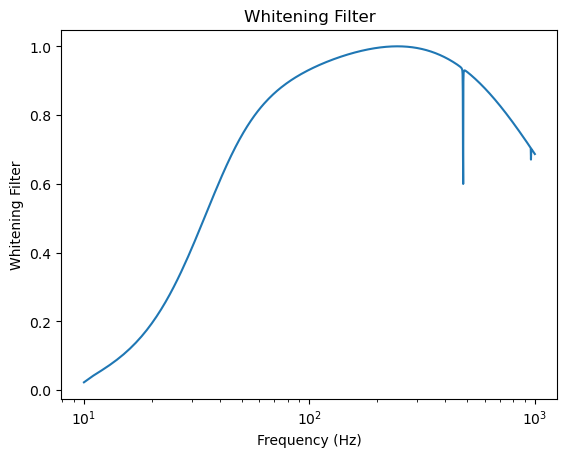

In [10]:
# calculate the whitening filter
expected_asd_values_interpolated = interpolate.interp1d(expected_asd_frequencies, expected_asd_values, kind='linear', fill_value='extrapolate')(freq_psd)

# calculate the whitening filter
whitening_filter = 1/expected_asd_values_interpolated

# normalise the whitening filter
whitening_filter /= np.max(whitening_filter)

# set the whitening filter to 1 where the observed PSD to 1 for frequencies below 10 Hz and above 1000 Hz
whitening_filter[freq_psd < f_lower] = 1
whitening_filter[freq_psd > f_upper] = 1


# plot the whitening filter
plt.plot(freq_psd, whitening_filter)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Whitening Filter')
plt.xscale('log')
plt.title('Whitening Filter')
plt.show()


In [11]:
# fourier transform the measured strain
strain_fft = np.fft.rfft(measured_strain)
freq_fft = np.fft.rfftfreq(len(measured_strain), d=sample_times[1] - sample_times[0])

# interpolate the whitening filter
whitening_filter_interpolated = interpolate.interp1d(freq_psd, whitening_filter, kind='linear', fill_value='extrapolate')(expected_asd_frequencies)

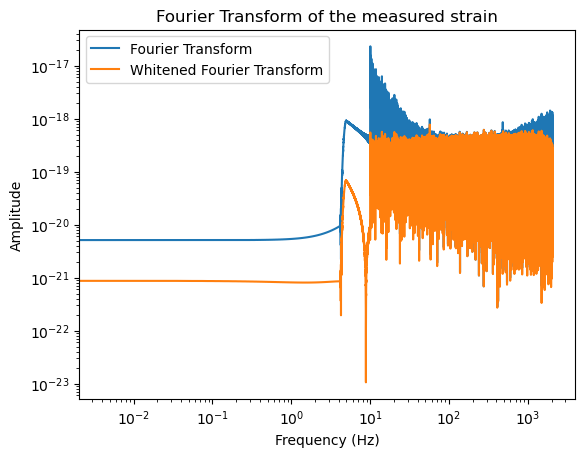

In [12]:
# interpolate the whitening filter to the frequencies of the fourier transform
whitening_filter_interpolated = interpolate.interp1d(freq_psd, whitening_filter, kind='linear', fill_value='extrapolate')(freq_fft)

# apply the whitening filter
whiten_data_fft = strain_fft * whitening_filter_interpolated

# plot the whitening filter and the fourier transform
plt.plot(freq_fft, np.abs(strain_fft), label='Fourier Transform')
plt.plot(freq_fft, np.abs(whiten_data_fft), label='Whitened Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Fourier Transform of the measured strain')
plt.show()



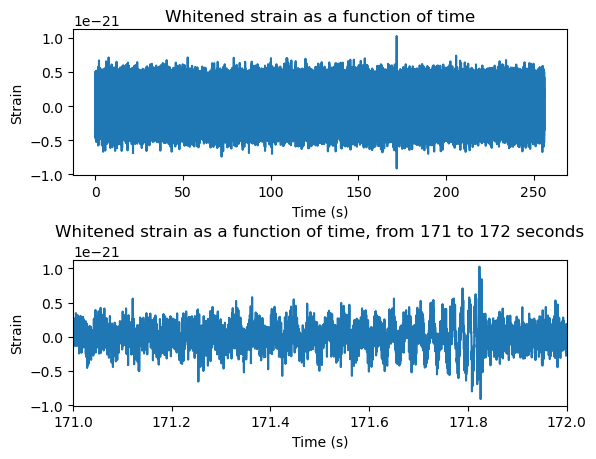

In [13]:
# inverse fourier transform the whitened data
whiten_data = np.fft.irfft(whiten_data_fft)
time_whiten = np.linspace(0, sample_times[-1], len(whiten_data))

# create two subplots

# 1. plot the measured strain and the whitened strain as a function of time
plt.subplot(2, 1, 1)
plt.plot(time_whiten, whiten_data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened strain as a function of time')

# make the two plot separated
plt.tight_layout(pad = 3.0)

# 2. plot the same data as above but zoomed in
plt.subplot(2, 1, 2)
plt.plot(time_whiten, whiten_data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Whitened strain as a function of time, from 171 to 172 seconds')
plt.xlim(171, 172)

plt.savefig('figures/whitened_data_time_series.png')
plt.show()


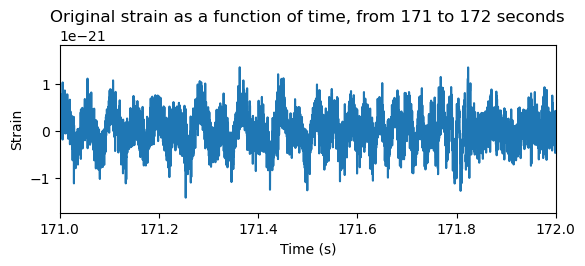

In [14]:
# 2. plot the original data
plt.subplot(2, 1, 2)
plt.plot(sample_times, measured_strain)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Original strain as a function of time, from 171 to 172 seconds')
plt.xlim(171, 172)

plt.show()

## Qn4. Construct the template signal

In [15]:
# use IMRPhenomD to generate a model of the strain

# define the parameters of the binary system

m1 = 30 # solar masses
m2 = 30 # solar masses
distance = 500 # Mpc

frequency_spacing = 1.0/16 # Hz
f_lower = 10.0 # Hz
f_upper = 1000.0 # Hz

inclination = np.pi/3 # radians
phase = 0 # radians
approximant = 'IMRPhenomD'

# generate the waveform in frequency domain
h_plus, h_cross = get_fd_waveform(approximant=approximant,
                                    mass1=m1,
                                    mass2=m2,
                                    distance=distance,
                                    f_lower=f_lower,
                                    delta_f=frequency_spacing,
                                    inclination=inclination,
                                    coa_phase=phase)
    

In [16]:
# define the domain of the frequency space
frequency = h_plus.sample_frequencies

Frequency spacing of the waveform:  0.00390625


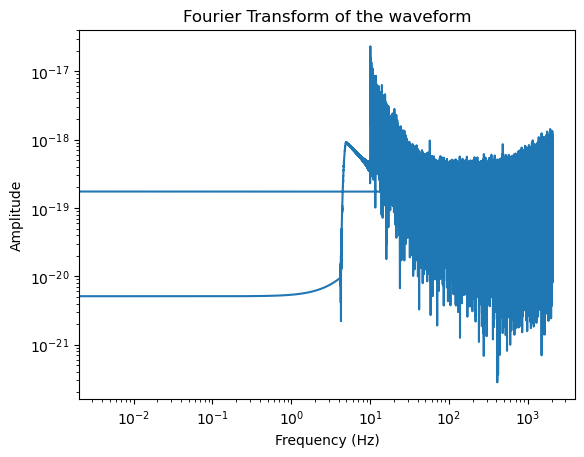

In [17]:
# fourier transform the waveform
strain_fft = np.fft.fft(measured_strain)
freq_fft = np.fft.fftfreq(len(measured_strain), d=sample_times[1] - sample_times[0])
frequency_spacing = freq_fft[1] - freq_fft[0]

# prirt the frequency spacing of the waveform
print ("Frequency spacing of the waveform: ", frequency_spacing)

# plot the fourier transform of the waveform
plt.plot(freq_fft, np.abs(strain_fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.title('Fourier Transform of the waveform')
plt.show()



In [18]:
freq = np.linspace(f_lower, f_upper, int((f_upper-f_lower)/frequency_spacing + 1))

In [19]:
# interpolate the fft of the waveform to the frequencies of the waveform
strain_fft_interpolated = interpolate.interp1d(freq_fft, strain_fft, kind="linear", fill_value="extrapolate")(freq_fft)
# strain_fft_interpolated = interpolate.interp1d(freq_fft, strain_fft, kind="linear", fill_value="extrapolate")(freq)

# interpolate the oberseved psd to the frequencies of the waveform
observed_psd_interpolated = interpolate.interp1d(freq_psd, observed_psd, kind="linear", fill_value="extrapolate")(freq_fft)

# interpolate the h_plus to the frequencies of the waveform
h_plus_interpolated = interpolate.interp1d(frequency, h_plus, kind="linear", fill_value="extrapolate")(freq_fft)

In [20]:
# # scale h such that the inner product is 1
# h_plus_interpolated /= inner_product(h_plus_interpolated, h_plus_interpolated, observed_psd_interpolated, frequency_spacing)

In [21]:
# print the lower and upper limit of the frequency range
print ("Lower limit of the frequency range: ", f_lower)
print ("Upper limit of the frequency range: ", f_upper)

# print the length of the interpolated strain_fft
print ("Length of the interpolated strain_fft: ", len(strain_fft_interpolated))

# print the length of h_plus
print ("Length of h_plus: ", len(h_plus_interpolated))

# print the length of observed_psd
print ("Length of observed_psd: ", len(observed_psd_interpolated))

# print the product of the length of signal in frequency domain and frequency spacing
print ("Product of the length of signal in frequency domain and frequency spacing: ", len(h_plus_interpolated) * frequency_spacing)



Lower limit of the frequency range:  10.0
Upper limit of the frequency range:  1000.0
Length of the interpolated strain_fft:  1048576
Length of h_plus:  1048576
Length of observed_psd:  1048576
Product of the length of signal in frequency domain and frequency spacing:  4096.0


/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_1325/4000568683.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(freq_fft, np.sqrt(observed_psd_interpolated), label='Observed ASD')


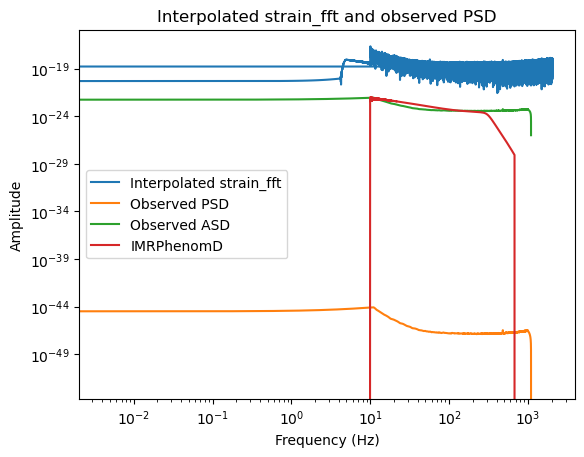

In [22]:
# plot the interpolated strain_fft and the observed psd
plt.plot(freq_fft, np.abs(strain_fft_interpolated), label='Interpolated strain_fft')
plt.plot(freq_fft, (observed_psd_interpolated), label='Observed PSD')
plt.plot(freq_fft, np.sqrt(observed_psd_interpolated), label='Observed ASD')
plt.plot(freq_fft, np.abs(h_plus_interpolated), label='IMRPhenomD')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Interpolated strain_fft and observed PSD')
plt.show()


In [23]:
# normalise the waveform
h_plus_interpolated /=(SNR(h_plus_interpolated, h_plus_interpolated, observed_psd_interpolated, frequency_spacing))

# check the normalisation
SNR_normalise = SNR(h_plus_interpolated, h_plus_interpolated, observed_psd_interpolated, frequency_spacing)
print ("SNR normalise: ", SNR_normalise)

SNR normalise:  1.0


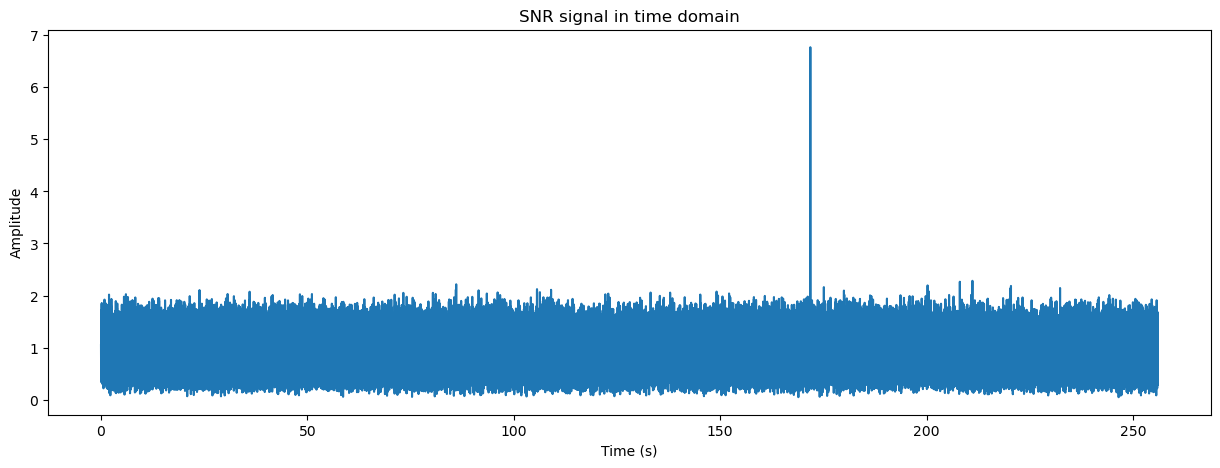

Maximum SNR:  6.768886528723206
Time at which maximum SNR occurs:  171.828125
Average SNR:  1.071710798865923


In [24]:
SNR_signal = np.sqrt(4 * np.abs(np.fft.ifft(h_plus_interpolated.conjugate() * strain_fft_interpolated/ observed_psd_interpolated)))
time = np.linspace(0, sample_times[-1], len(SNR_signal))


# plot the SNR signal
plt.figure(figsize=(15, 5))
plt.plot(time, SNR_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('SNR signal in time domain')
plt.savefig('figures/matched_filter_snr.png')
plt.show()

# find the maximum SNR and the time at which it occurs
max_SNR = np.max(np.abs(SNR_signal)/SNR_normalise)
print ("Maximum SNR: ", max_SNR)
max_SNR_time = time[np.argmax(np.abs(SNR_signal)/SNR_normalise)]
print ("Time at which maximum SNR occurs: ", max_SNR_time)

# find the average SNR
average_SNR = np.mean(np.abs(SNR_signal)/SNR_normalise)
print ("Average SNR: ", average_SNR)


